## Creating synthetic data


Loading the VERDICT MODEL 
\begin{equation}
 E_{\textrm{VERDICT}}= \underbrace{f_{\textrm{Tumor}}\overbrace{E(D|\lambda_{\textrm{intra}})}^{\textrm{Sphere}}}_{\textrm{Tumor Cells}} + \underbrace{f_{\textrm{extra}}\overbrace{E(\cdot|\lambda_{iso})}^{\textrm{Ball}}}_{\textrm{Hindered Extra-Cellular}}+\underbrace{f_{blood}\overbrace{E(\lambda_\parallel, \boldsymbol{\mu})}^{\textrm{Stick}}}_{\textrm{Vascular}}
\end{equation}

In [3]:
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel, MultiCompartmentSphericalHarmonicsModel
import numpy as np
from scipy.stats import rice
import matplotlib as mpl
import matplotlib.gridspec as gridspec


sphere = sphere_models.S4SphereGaussianPhaseApproximation(diffusion_constant=1.2e-9)
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()

verdict_mod = MultiCompartmentModel(models=[sphere, ball, stick])

verdict_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 2e-9) #2
verdict_mod.set_fixed_parameter('C1Stick_1_lambda_par',8e-9)
verdict_mod.set_fixed_parameter('C1Stick_1_mu',[1.570796326794897,0])
verdict_mod.parameter_names
verdict_mod.parameter_cardinality

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.


OrderedDict([('S4SphereGaussianPhaseApproximation_1_diameter', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1),
             ('partial_volume_2', 1)])

Loading acquisition scheme

In [4]:
from dmipy.core.acquisition_scheme import acquisition_scheme_from_schemefile
from os.path import join

acquisition_path = "/home/thea/Desktop/Master-project/data/3466.scheme"

scheme= acquisition_scheme_from_schemefile(acquisition_path)

## Creating parameter arrays

With random values of R and the IC,EES and VASC volume fractions

In [211]:
def all_comb(ic,ec,vasc,radi):

    comb= []

    for i in ic:
        for j in ec:
            for k in vasc:
                if i+j+k == 1:
                    for r in radi:
                        for l in range(10):
                            comb.append([r,i,j,k])
    return comb

In [215]:
#Creating parameter vector

ranges = np.arange(0.1,1.1,0.1)
ic = ranges; ec = ranges; vasc = ranges
radi = np.arange(2e-6,15e-6,0.5e-6)*2

all_combinations = all_comb(ic,ec,vasc,radi)

#final = fill(all_combinations,4)

parameter_vector = np.array(all_combinations)
parameter_vector.shape

(9180, 4)

In [218]:
pred_radi = np.load('results/radii_9180.npy')
pred_f_sphere = np.load('results/f_sphere_9180.npy')
pred_f_ball = np.load('results/f_ball_9180.npy')
pred_f_stick = np.load('results/f_stick_9180.npy')
pred_signal= np.load('results/signal_9180.npy')

pred_radi.shape

(9180, 1)

Visualization of the parameters:

In [219]:
from sklearn.metrics import r2_score, mean_absolute_error
print("f_sphere")
print("r2_score: " +str(r2_score(parameter_vector[:,1].flatten(),pred_f_sphere.squeeze())))
print(" mean_absoulte_error: " + str(mean_absolute_error(parameter_vector[:,1].flatten(),pred_f_sphere.squeeze())))

print("f_ball")
print("r2_score: " +str(r2_score(parameter_vector[:,2].flatten(),pred_f_ball.squeeze())))
print(" mean_absoulte_error: " + str(mean_absolute_error(parameter_vector[:,2].flatten(),pred_f_ball.squeeze())))

print("f_stick")
print("r2_score: " +str(r2_score(parameter_vector[:,3].flatten(),pred_f_stick.squeeze())))
print(" mean_absoulte_error: " + str(mean_absolute_error(parameter_vector[:,3].flatten(),pred_f_stick.squeeze())))

print("radi:")
print("r2_score: " + str(r2_score(parameter_vector[:,0].flatten()/parameter_vector[:,0].flatten().max(),pred_radi.squeeze()/pred_radi.squeeze().max())))
print(" mean_absoulte_error: " + str(mean_absolute_error(parameter_vector[:,0].flatten(),pred_radi.squeeze())))

f_sphere
r2_score: 0.9954944698698692
 mean_absoulte_error: 0.010617784680169664
f_ball
r2_score: 0.994067326753925
 mean_absoulte_error: 0.012304616154603697
f_stick
r2_score: 0.9995949302324486
 mean_absoulte_error: 0.0029299942869896066
radi:
r2_score: 0.9820794725711891
 mean_absoulte_error: 8.594927792323643


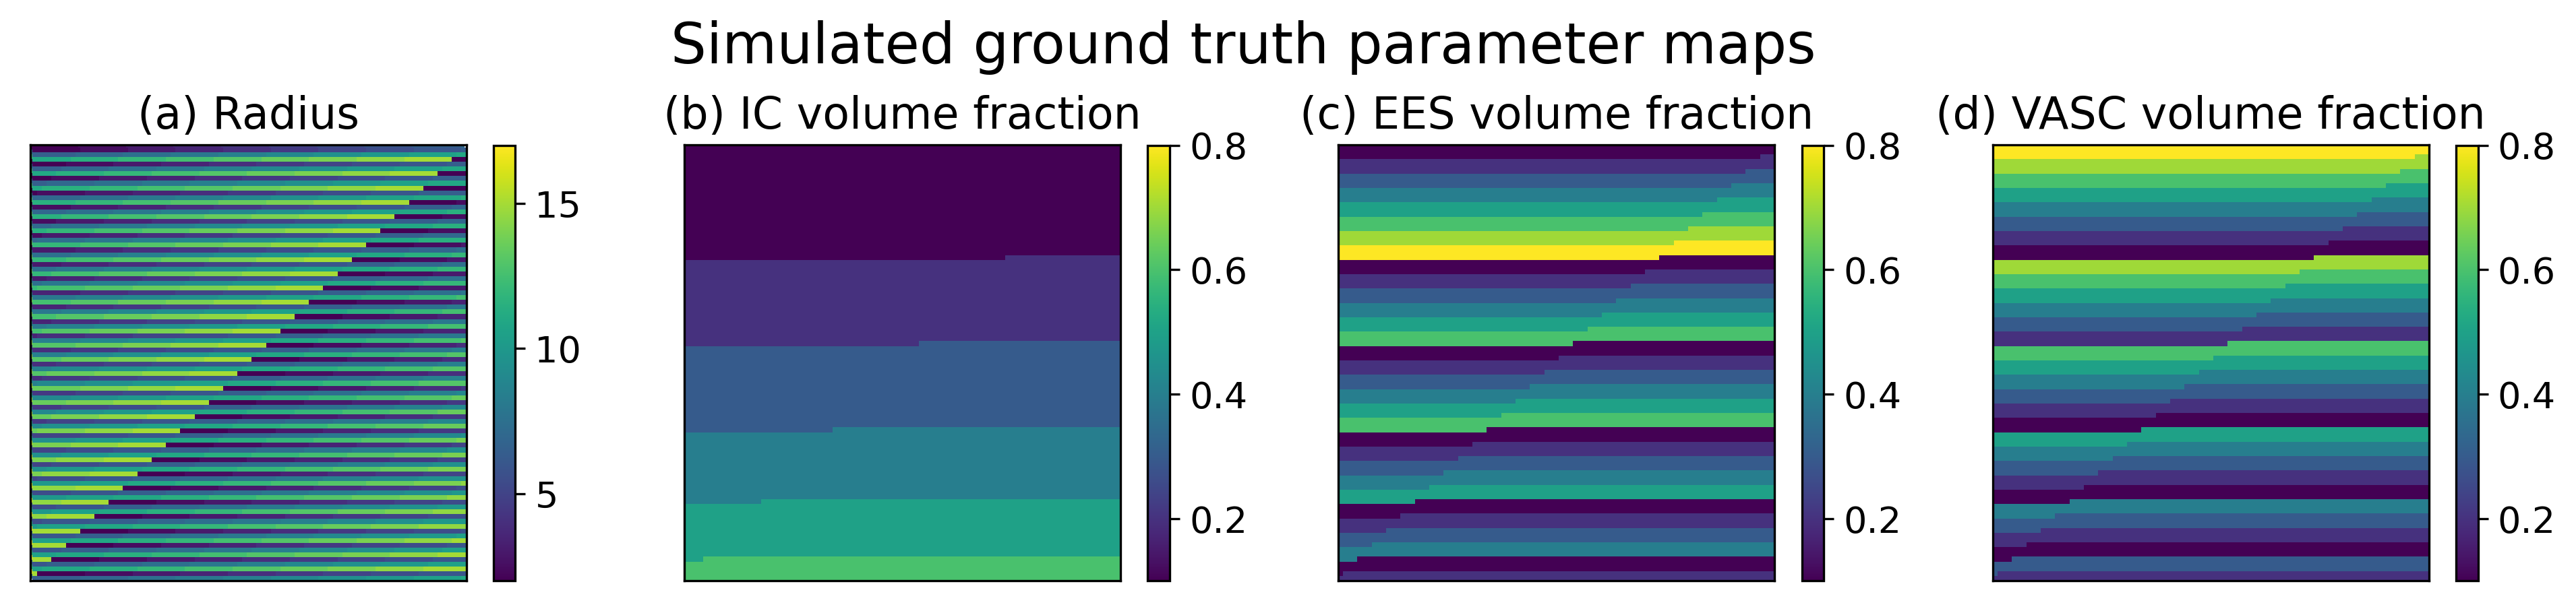

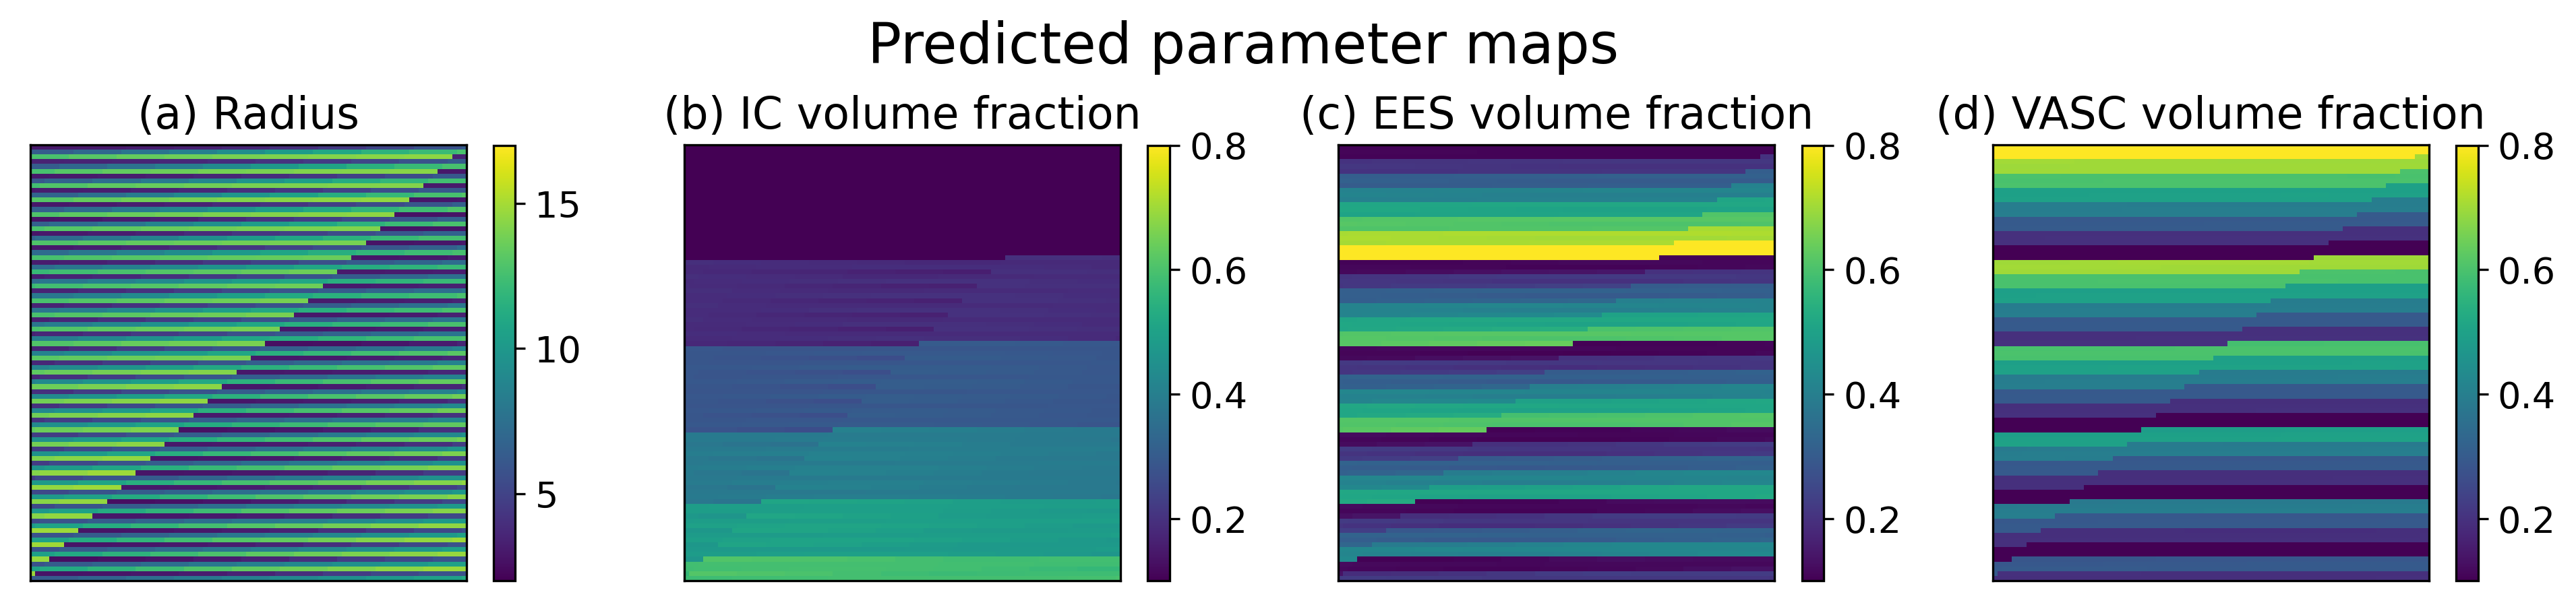

In [222]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numpy import isin
%matplotlib inline

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(1,4, figsize=(16,3.5))
fig.suptitle('Simulated ground truth parameter maps',fontsize=20)

names = ['(a) Radius','(b) IC volume fraction','(c) EES volume fraction', '(d) VASC volume fraction']

vis =  parameter_vector[:91*91].reshape(91,91,4)
radi = vis[:,:,0]*1e6/2
image = ax[0].imshow(radi)
mesh = ax[0].pcolormesh(radi)
mesh.set_clim(2,17)
fig.colorbar(mesh,ax=ax[0],shrink=0.8)
ax[0].set_title(names[0])
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

for i in [1,2,3]:
    image = ax[i].imshow(vis[:,:,i])
    mappable = image
    mappable.set_clim(0.1, 0.8)
    fig.colorbar(image,ax=ax[i],shrink=0.8)
    ax[i].set_title(names[i])
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

fig, ax = plt.subplots(1,4, figsize=(16,3.5))
fig.suptitle('Predicted parameter maps',fontsize=20)

predictions =  [pred_radi,pred_f_sphere,pred_f_ball ,pred_f_stick]

for i in [0,1,2,3]:
    image = ax[i].imshow(predictions[i][:91*91].reshape(91,91))
    mappable = image
    if i == 0:
        mappable.set_clim(2,17)
    else:
        mappable.set_clim(0.1, 0.8)
    fig.colorbar(mappable, ax=ax[i], shrink=0.8)
    ax[i].set_title(names[i])
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)



In [194]:
parameter_vector[1420,0]*1e6/2

20.000000000000004

In [195]:
pred_radi[1420]

array([14.76264668])

## Simulating new data from fake parameters
and visualizing 

In [216]:
simulated_signal = verdict_mod.simulate_signal(scheme,parameter_vector)

In [217]:

np.save('simulated_9180.npy',simulated_signal)
simulated_signal.shape

(9180, 3466)

In [131]:
pred_signal.shape

(3230, 3466)

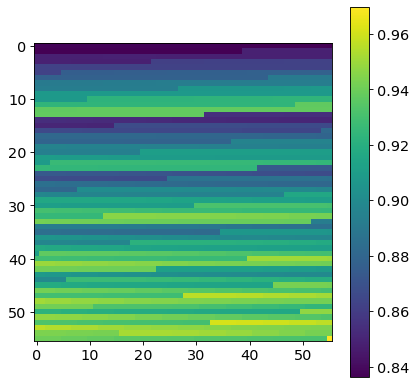

In [134]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,6),dpi=80)
plt.imshow(pred_signal[:56*56].reshape(56,56,3466)[:,:,1])
plt.colorbar()


## Adding noise

Normal distribution noise

In [10]:
# Normal noise
noise = np.random.normal(0,.005,simulated_signal.shape)
new_signal = simulated_signal+noise

Rice distribution noise

In [11]:
def rician_noise(signal,TE=50,b=1000):

    scale = 0.0001*np.sqrt(b)*(TE/30)**2

    rician_noise = rice.rvs(0.8,scale=scale,size = signal.shape)
    rician_image = signal*(1-rician_noise)

    return rician_noise, rician_image

In [12]:
def plot_augmentations(rows,cols,images,names,colorbar=True,title=None):

    plt.rcParams["figure.dpi"] = 300

    fig,axes = plt.subplots(rows,cols,figsize=(10,5))


    if title is not None:
        fig.suptitle(title,fontsize=20)

    for i,ax in zip(range(len(images)),axes.flat):

        image = ax.imshow(images[i][:,:,1])
        title = ax.set_title(names[i])
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)

        if colorbar == True:
            cb=fig.colorbar(image,ax=ax,shrink=1/cols)
        
    if cols*rows > len(images):
        to_remove = len(images)-cols*rows
        fig.delaxes(axes[-1][to_remove])

    plt.tight_layout()

Visualizing images with noise

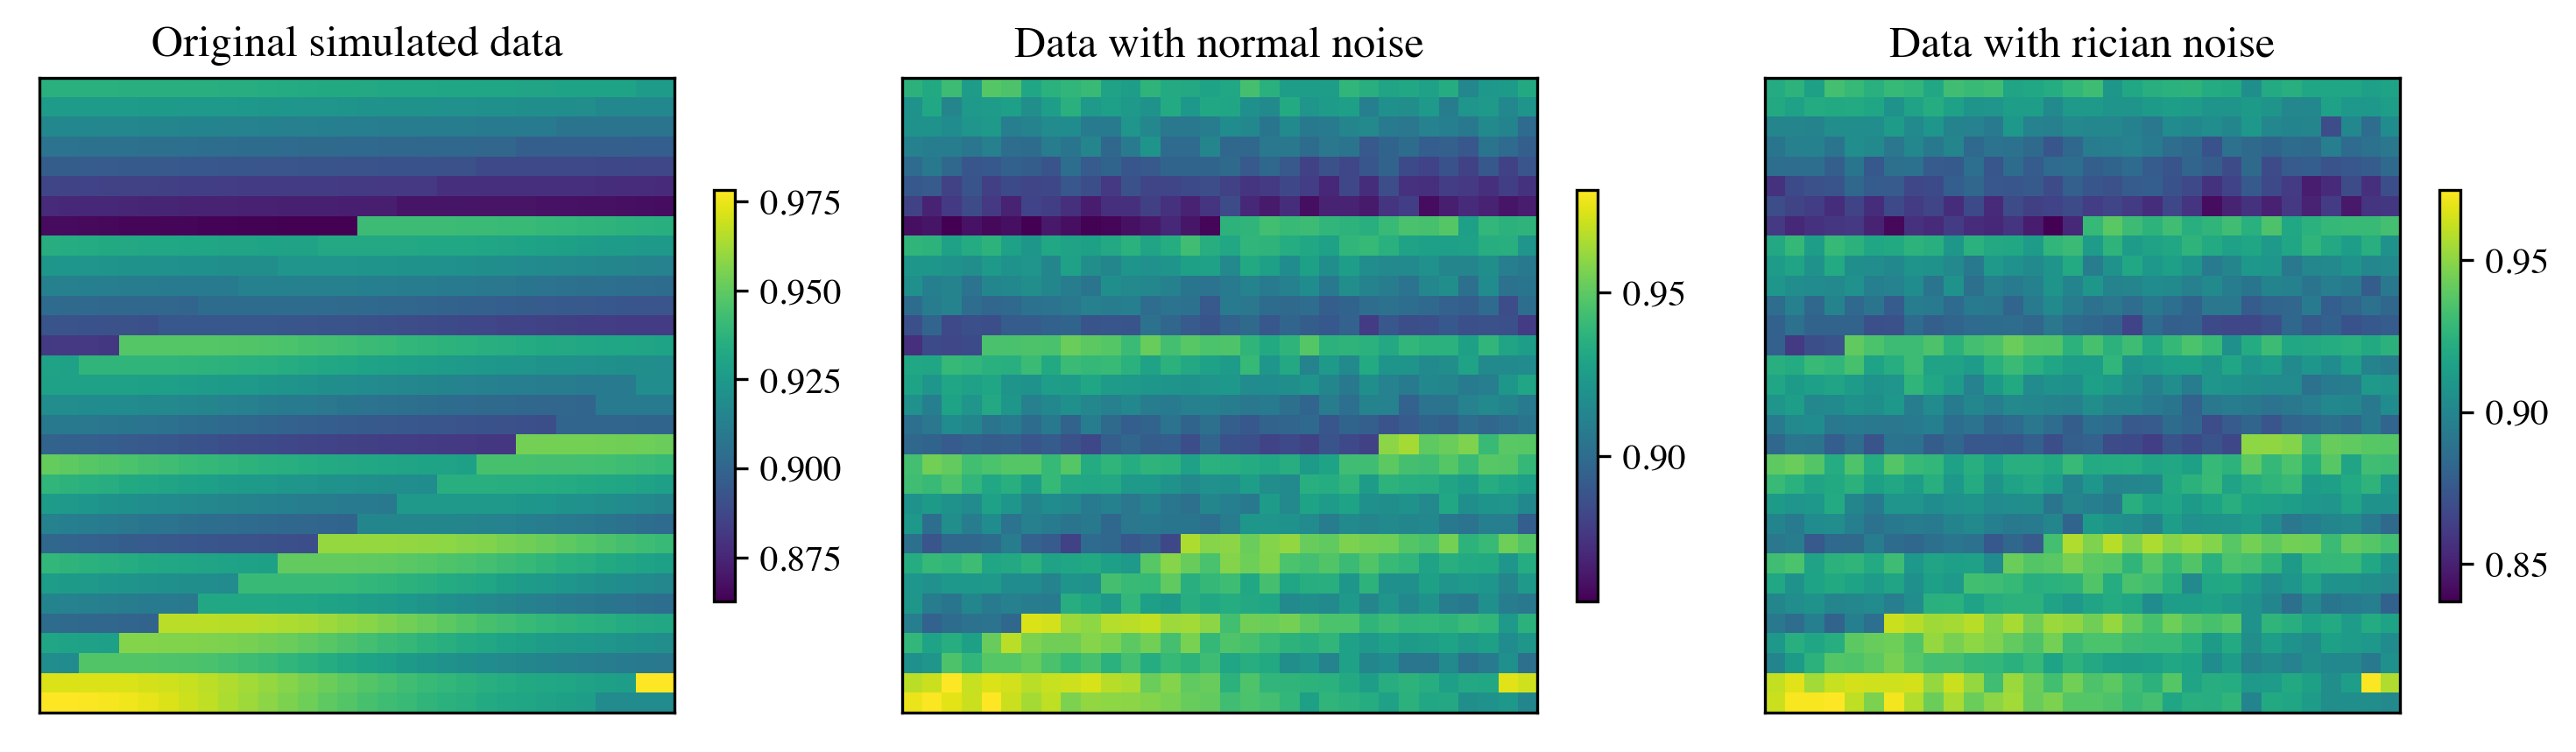

In [13]:
# Visualization

_,ric = rician_noise(simulated_signal)

plot_augmentations(1,3,[simulated_signal,new_signal,ric],['Original simulated data','Data with normal noise','Data with rician noise'])


Visualizing different rician noises for different b-values

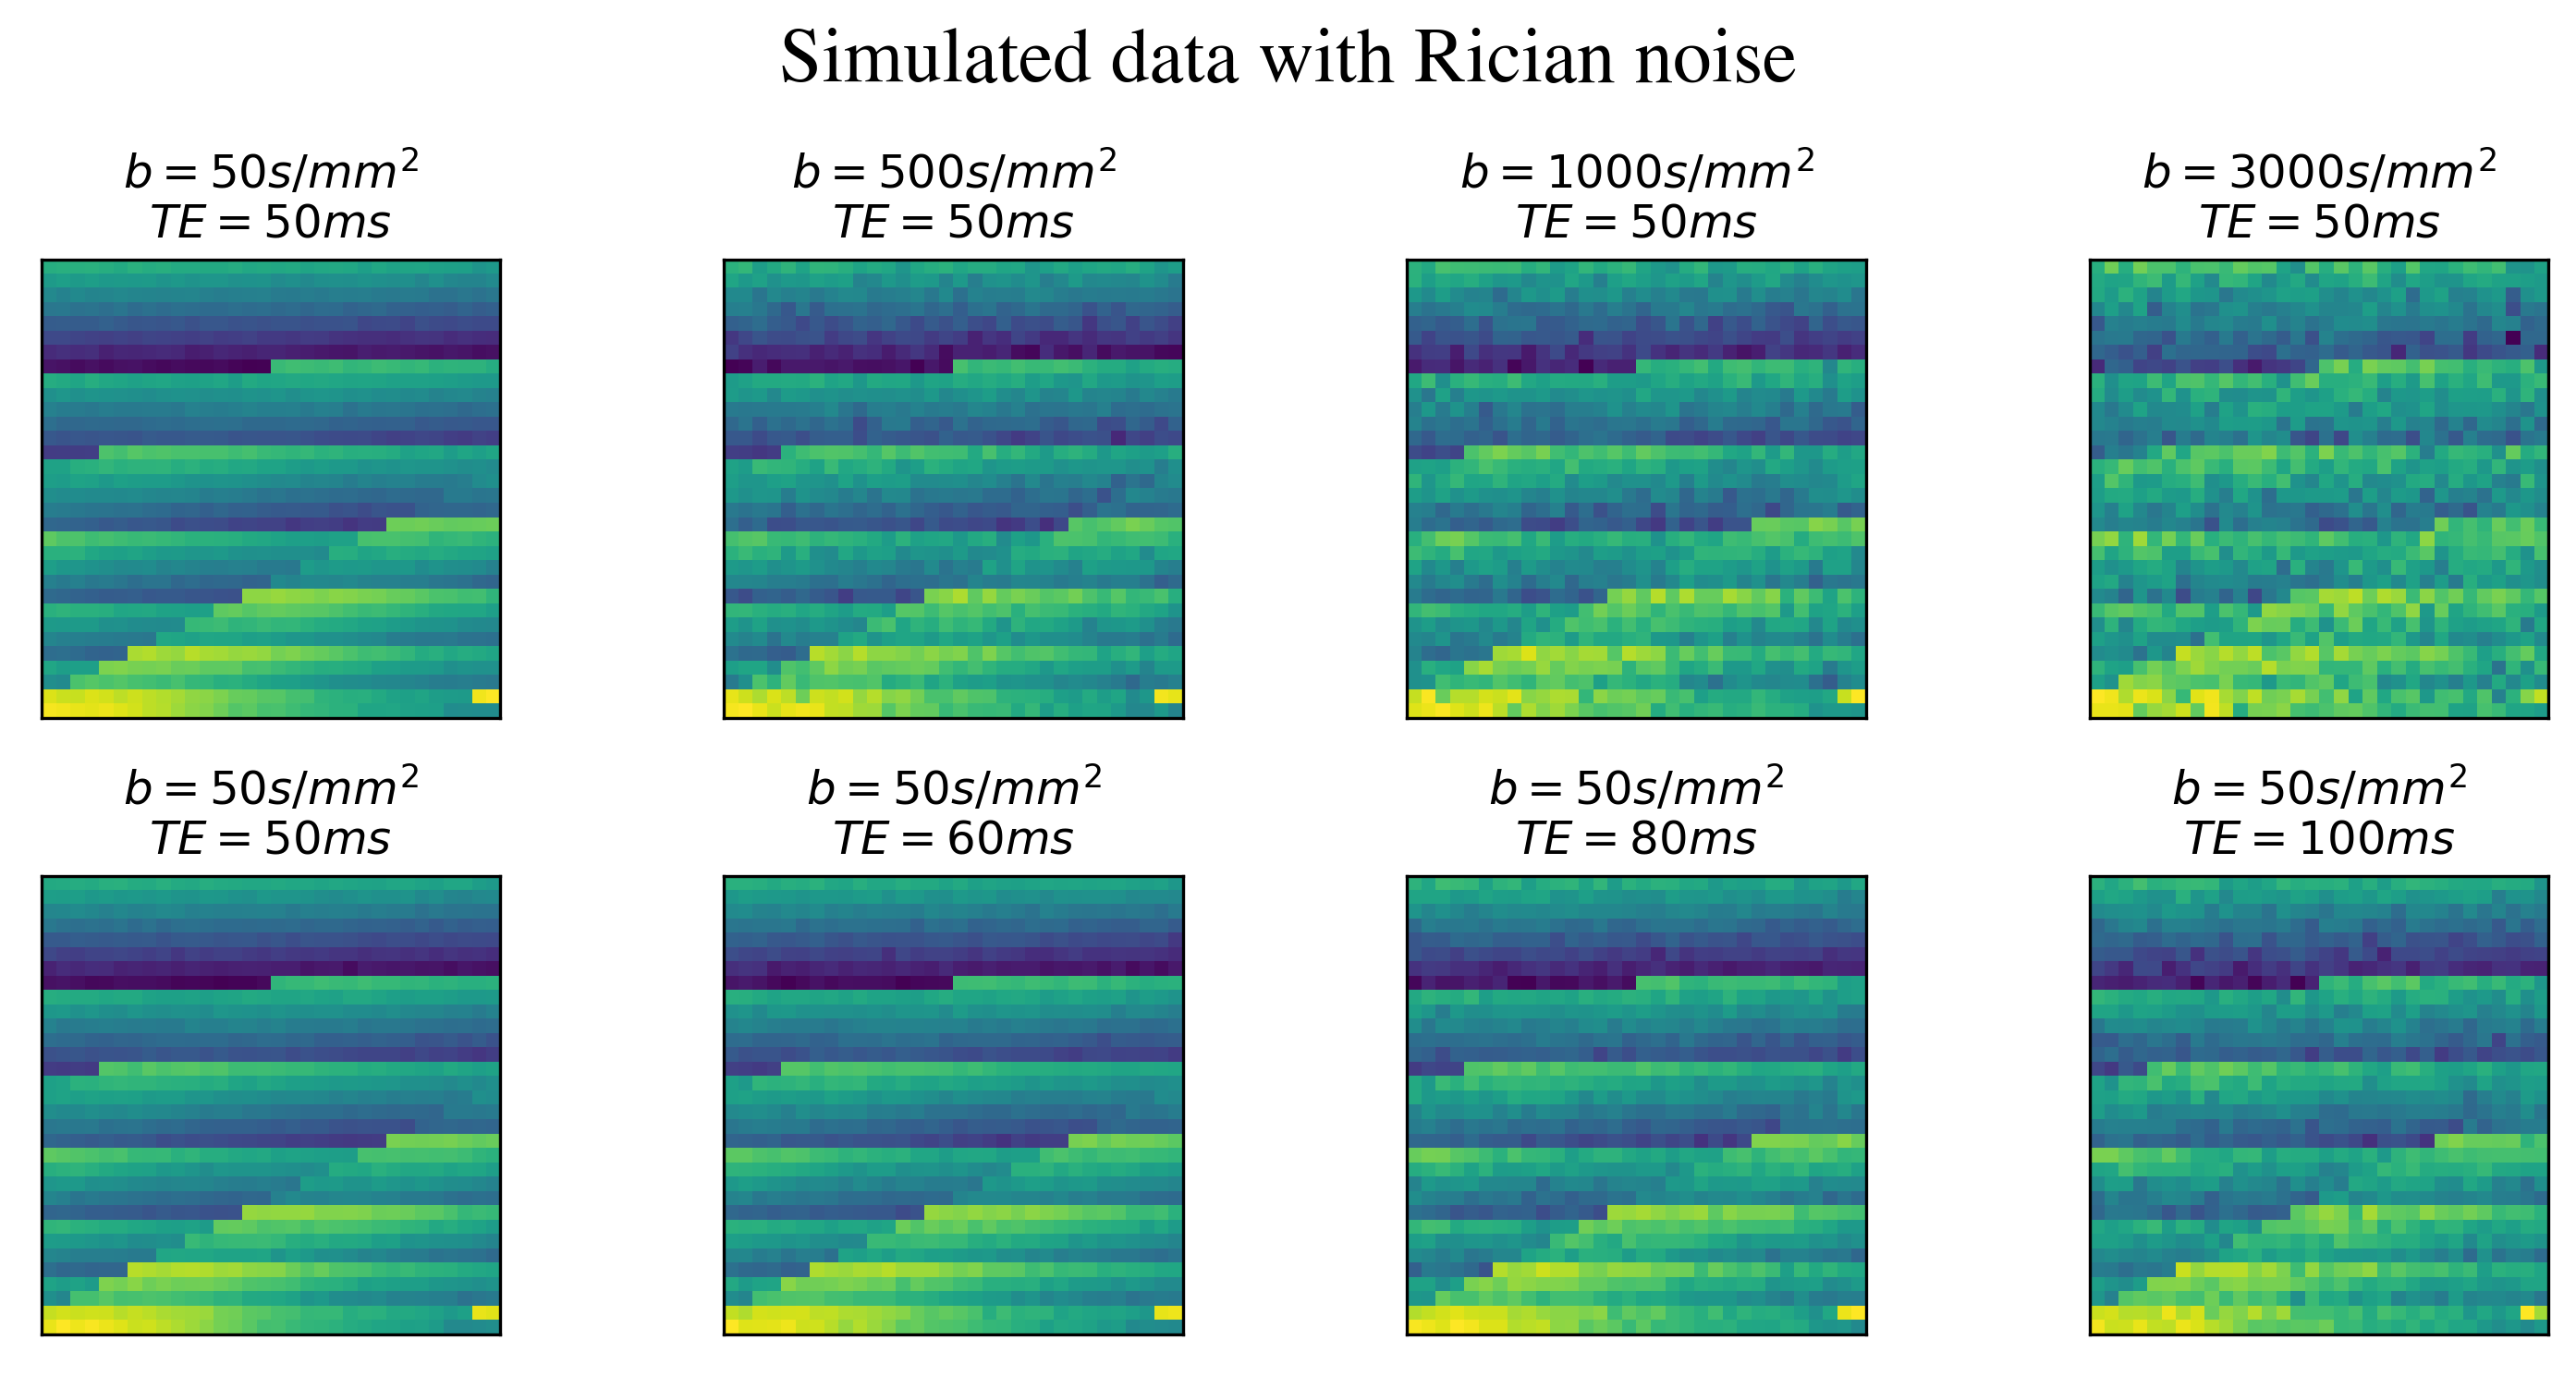

In [14]:
rician_images = []; names = []
b_values = [50,500,1000,3000]
TE_values = [50,60,80,100] #[ms]

for b in b_values:
    _, rician_image = rician_noise(simulated_signal,TE_values[0],b)
    rician_images.append(rician_image)
    names.append('$b = %d s/mm^2$\n$TE = %d ms $' %(b,TE_values[0]))


for TE in TE_values:
    _,rician_image = rician_noise(simulated_signal,TE,b_values[0])
    rician_images.append(rician_image)
    names.append('$b = %d s/mm^2$\n$TE = %d ms $' %(b_values[0],TE))


plot_augmentations(2,4,rician_images,names,colorbar=False,title='Simulated data with Rician noise')

## Testing

# Visualization of noise distribution in air voxels

Text(0, 0.5, 'Density')

/Users/theavage/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


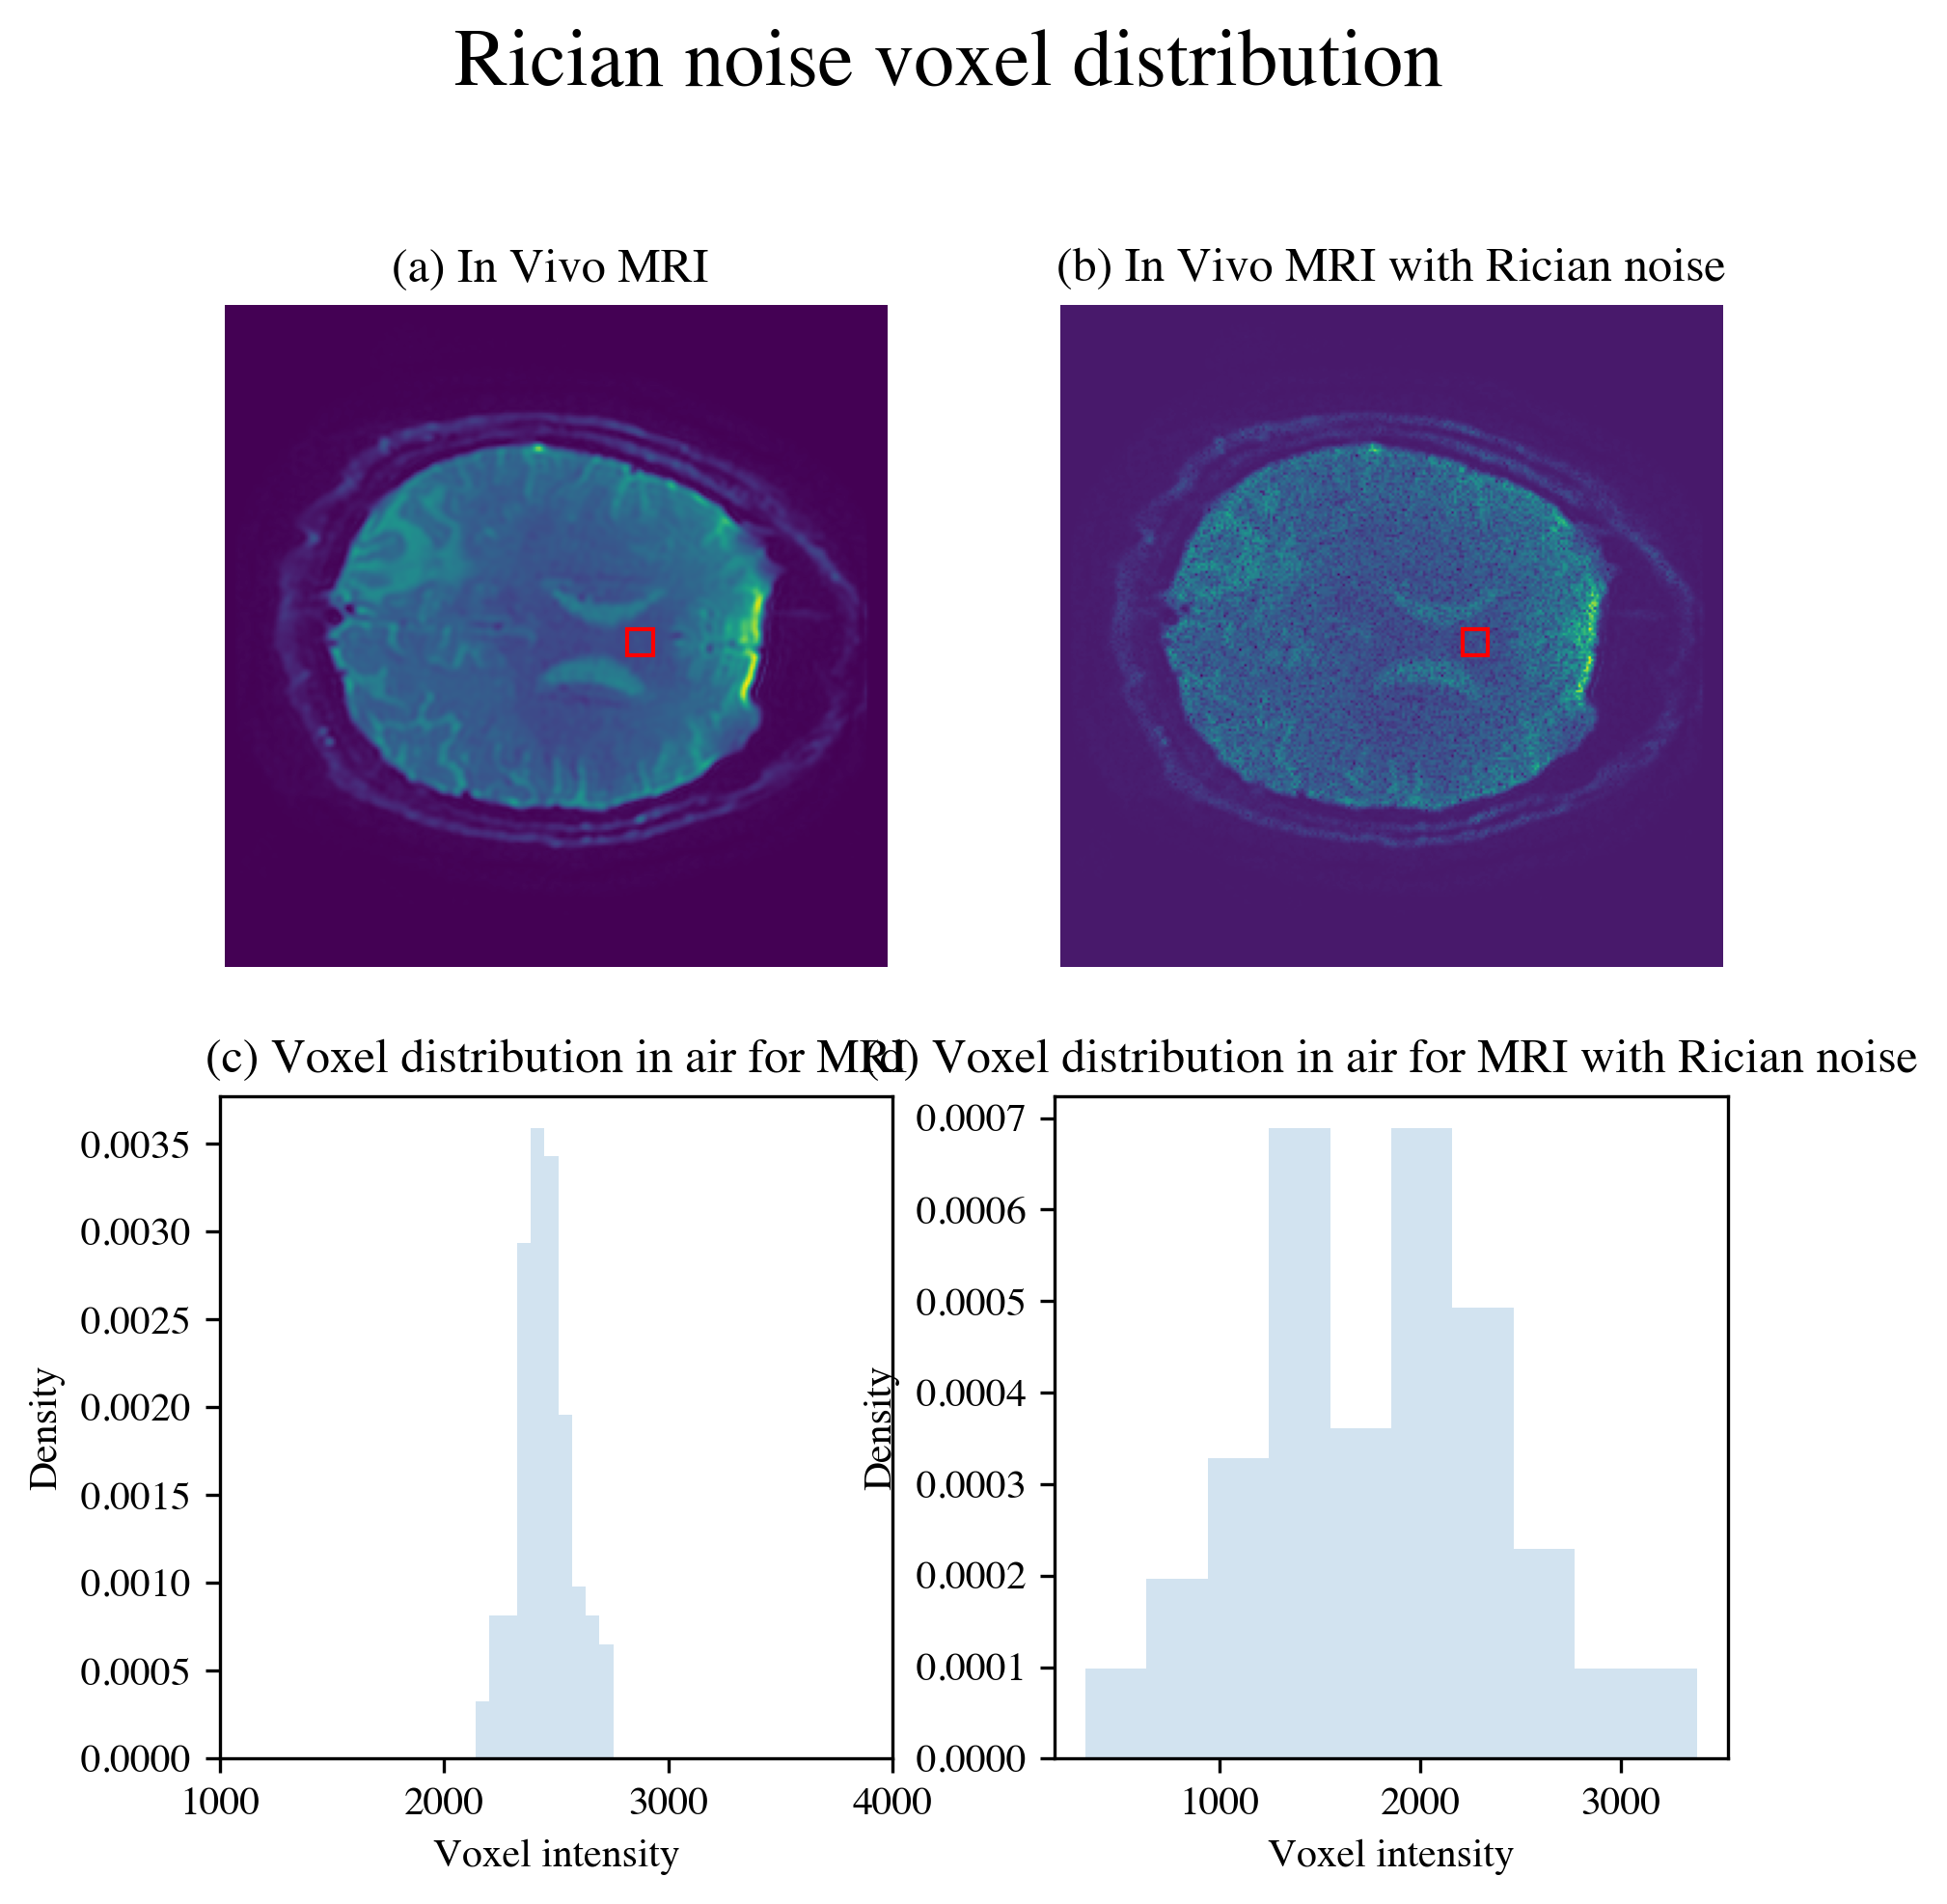

In [38]:
import dipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
real_image = dipy.data.fetcher.load_nifti_data(join(acquisition_path_GS55,"GS55_all.nii.gz"))
noise, noisy_real_img = rician_noise(real_image[:,:,:,0],200,3000)

fig, ax = plt.subplots(2,2,constrained_layout=True,figsize=(7,7))
fig.suptitle('Rician noise voxel distribution',fontsize=20)

ax=ax.flat
image = ax[0].imshow(real_image[:, :, 15, 0])
rect = patches.Rectangle((155,125),10,10,linewidth=1,edgecolor='r',facecolor='none')
ax[0].add_patch(rect)
ax[0].set_axis_off()
ax[0].set_title('(a) In Vivo MRI ')

image = ax[1].imshow(noisy_real_img[:, :, 15])
rect = patches.Rectangle((155,125),10,10,linewidth=1,edgecolor='r',facecolor='none')
ax[1].add_patch(rect)
ax[1].set_axis_off()
ax[1].set_title('(b) In Vivo MRI with Rician noise')


ax[2].hist(real_image[155:165,125:135,12,0].flatten(), density=True, histtype='stepfilled', alpha=0.2)
ax[2].set_title('(c) Voxel distribution in air for MRI')
ax[2].set_xlim([1000,4000])
ax[2].set_xlabel('Voxel intensity')
ax[2].set_ylabel('Density')


ax[3].hist(noisy_real_img[155:165,125:135,0].flatten(), density=True, histtype='stepfilled', alpha=0.2)
ax[3].set_title('(d) Voxel distribution in air for MRI with Rician noise')
ax[3].set_xlabel('Voxel intensity')
ax[3].set_ylabel('Density')

